In [1]:
import numpy as np
import scipy.sparse as sps
from scipy.sparse.linalg import cg as sp_cg

import jlinops
from ias import IASSolver

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['text.usetex'] = True
mpl.rc('text.latex', preamble=r'\usepackage{amsmath}')

dcolors = {
    "dartmouth_green": "#00693e", 
    "forest_green": "#12312b",
    "river_blue": "#267aba",
    "autumn_brown": "#643c20",
    "bonfire_red": "#9d162e",
    "river_navy": "#003c73",
    "spring_green": "#c4dd88",
    "rich_spring_green": "#a5d75f",
    "summer_yellow": "#f5dc69",
    "bonfire_orange": "#ffa00f",
    "tuck_orange": "#e32d1c",
    "web_violet": "#8a6996",
    "midnight_black": "#000000",
}

from matplotlib.ticker import MaxNLocator

In [2]:
def test_signal():

    dom = np.linspace(0, 1, 1000)
    result = np.zeros(1000)
    result = 2*np.sin( (50*np.pi)*dom ) + 25*dom
    result[400:] += 50
    result[700:] += 70

    return result

In [3]:
ground_truth = test_signal()
noise_var = 10.0
noise_sigma = np.sqrt(noise_var)
np.random.seed(0)
y_obs = ground_truth + noise_sigma*np.random.normal(size=len(ground_truth))
n = len(y_obs)

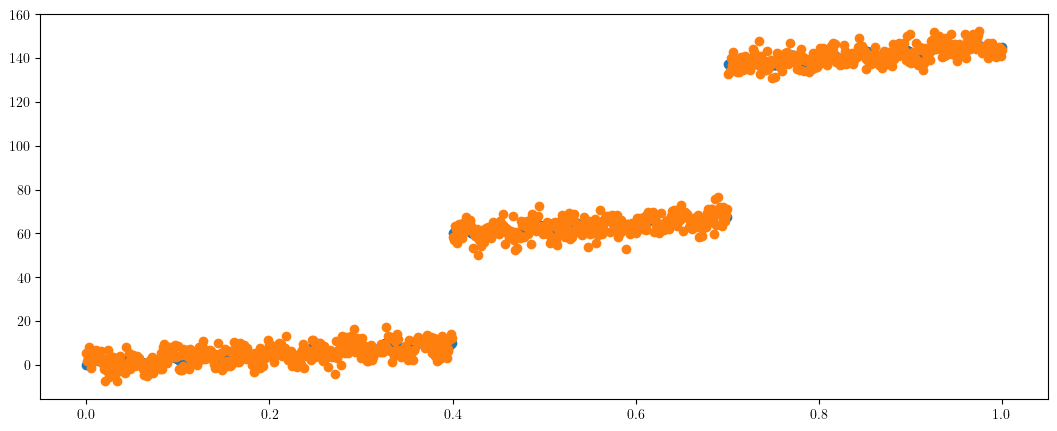

In [4]:
plt.figure(figsize=(13,5))
dom = np.linspace(0, 1, n)
plt.scatter(dom, ground_truth)
plt.scatter(dom, y_obs)
plt.show()

In [5]:
F = jlinops.IdentityOperator( (n,n) )

R1_mat, W1_mat = jlinops.first_order_derivative_1d(n, boundary="none") 
W1 = jlinops.MatrixLinearOperator(W1_mat)
R1 = jlinops.MatrixLinearOperator(R1_mat)

R2_mat, W2_mat = jlinops.second_order_derivative_1d(n, boundary="none")
W2 = jlinops.MatrixLinearOperator(W2_mat)
R2 = jlinops.MatrixLinearOperator(R2_mat)

R3_mat, W3_mat = jlinops.third_order_derivative_1d(n, boundary="none")
W3 = jlinops.MatrixLinearOperator(W3_mat)
R3 = jlinops.MatrixLinearOperator(R3_mat)

In [6]:
delta = 1e-8

def R1pinv_factory(theta):
    return jlinops.BandedCholeskyPinvOperator( jlinops.MatrixLinearOperator( sps.diags( 1.0/np.sqrt(theta) ) @ R1_mat ), delta=delta )

pdata1 = {
    "W": W1,
    "Rpinv_factory": R1pinv_factory,
}


def R2pinv_factory(theta):
    return jlinops.BandedCholeskyPinvOperator( jlinops.MatrixLinearOperator( sps.diags( 1.0/np.sqrt(theta) ) @ R2_mat ), delta=delta )

pdata2 = {
    "W": W2,
    "Rpinv_factory": R2pinv_factory,
}


def R3pinv_factory(theta):
    return jlinops.BandedCholeskyPinvOperator( jlinops.MatrixLinearOperator( sps.diags( 1.0/np.sqrt(theta) ) @ R3_mat ), delta=delta )

pdata3 = {
    "W": W3,
    "Rpinv_factory": R3pinv_factory,
}

In [151]:
# Prior parameters
reg_lambda = 5
vartheta = 2/(reg_lambda**2)
hyperparams_r1 = {
    "prior": {
        "r": 1.0,
        "beta": 1.5 + 1e-3,
        "vartheta": vartheta,
    },
    "noise_var": {
        "r": -1.0,
        "beta": 1,
        "vartheta": 1e-4,
    }
}


hyperparams_r2 = {
    "prior": {
        "r": 1.0,
        "beta": 1.5 + 1e-3,
        "vartheta": vartheta,
    },
    "noise_var": {
        "r": -1.0,
        "beta": 1,
        "vartheta": 1e-4,
    }
}


hyperparams_r3 = {
    "prior": {
        "r": 1.0,
        "beta": 1.5 + 1e-3,
        "vartheta": vartheta,
    },
    "noise_var": {
        "r": -1.0,
        "beta": 1,
        "vartheta": 1e-4,
    }
}

# Create solvers
solver_r1 = IASSolver(F, R1, y_obs, hyperparams_r1, noise_var=None, pdata=pdata1)
solver_r2 = IASSolver(F, R2, y_obs, hyperparams_r2, noise_var=None, pdata=pdata2)
solver_r3 = IASSolver(F, R3, y_obs, hyperparams_r3, noise_var=None, pdata=pdata3)

In [152]:
# Initialize everything at the least-squares reconstruction?
x0_r1, _ = sp_cg( (F.T @ F) + 1.0*(R1.T @ R1), F.T @ y_obs, tol=1e-4 )
x0_r2, _ = sp_cg( (F.T @ F) + 1.0*(R2.T @ R2), F.T @ y_obs, tol=1e-4 )
x0_r3, _ = sp_cg( (F.T @ F) + 1.0*(R3.T @ R3), F.T @ y_obs, tol=1e-4 )

In [153]:
data_r1 = solver_r1.solve(max_iters=100, x0=x0_r1, 
                          priorconditioning=False, early_stopping=True, 
                          warmstarting=True, eps=1e-4,
                          x_update_solver_params={"tol":1e-3})

In [154]:
data_pr1 = solver_r1.solve(max_iters=100, x0=x0_r1, 
                           priorconditioning=True, early_stopping=True, 
                           warmstarting=True, eps=1e-4,
                           x_update_solver_params={"tol":1e-3})

In [155]:
data_r2 = solver_r2.solve(max_iters=100, x0=x0_r2, 
                          priorconditioning=False, early_stopping=True, 
                          warmstarting=True, eps=1e-4,
                          x_update_solver_params={"tol":1e-3})

In [156]:
data_pr2 = solver_r2.solve(max_iters=100, x0=x0_r2, 
                          priorconditioning=True, early_stopping=True, 
                          warmstarting=True, eps=1e-4,
                          x_update_solver_params={"tol":1e-3})

In [157]:
data_r3 = solver_r3.solve(max_iters=100, x0=x0_r3, 
                           priorconditioning=False, early_stopping=True, 
                           warmstarting=True, eps=1e-4,
                           x_update_solver_params={"tol":1e-3})

In [158]:
data_pr3 = solver_r3.solve(max_iters=100, x0=x0_r3, 
                           priorconditioning=True, early_stopping=True, 
                           warmstarting=True, eps=1e-4,
                           x_update_solver_params={"tol":1e-3})

# Plots

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


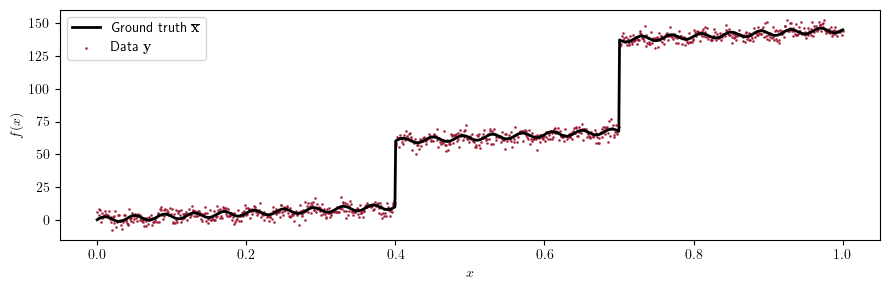

In [159]:
plt.figure(figsize=(9,3))

plt.plot(dom, ground_truth, label="Ground truth $\overline{\mathbf{x}}$", lw=2.0, color="black")
plt.scatter(dom, y_obs, s=0.9, alpha=0.8, color=dcolors["bonfire_red"], label="Data $\mathbf{y}$")
plt.title("")
plt.ylabel("$f(x)$")
plt.xlabel("$x$")
plt.legend()

plt.tight_layout()
plt.savefig("toy_data.png", dpi=250, bbox_inches="tight")
plt.savefig("toy_data.eps", dpi=250, bbox_inches="tight")

plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


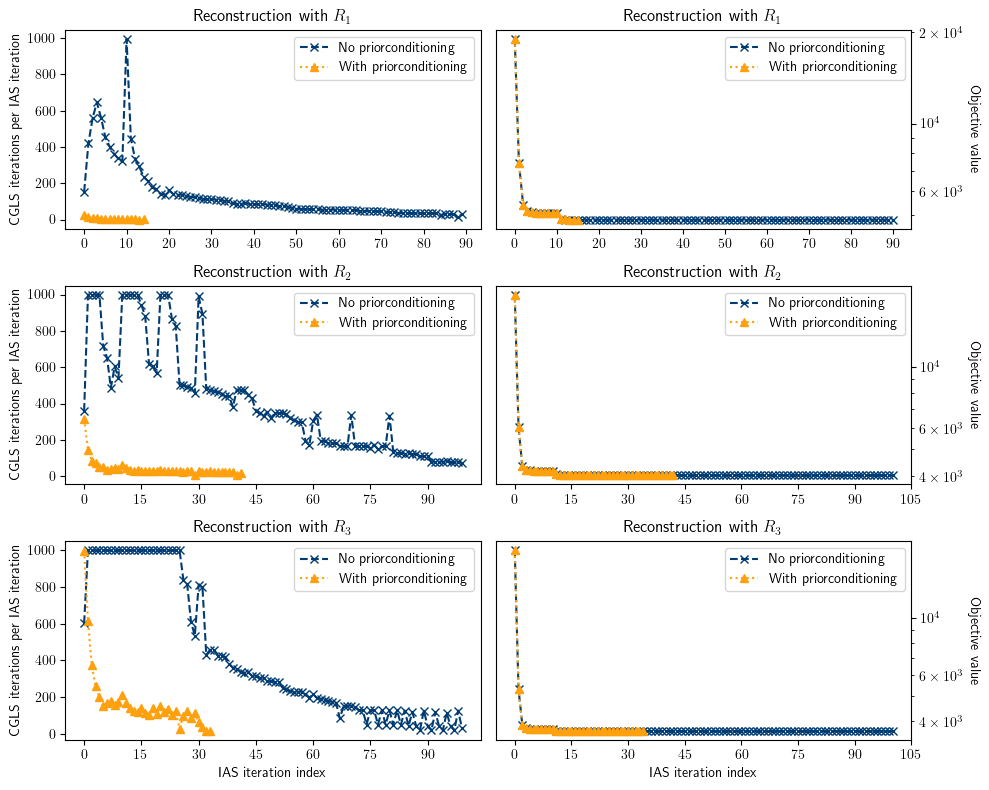

In [160]:
fig, axs = plt.subplots(3,2,figsize=(10,8))


axs[0,0].plot(data_r1["n_cg_its_per_iteration"], color=dcolors["river_navy"], label="No priorconditioning", marker="x", ls="--")
axs[0,0].plot(data_pr1["n_cg_its_per_iteration"], color=dcolors["bonfire_orange"], label="With priorconditioning", marker="^", ls=":")
axs[0,1].semilogy(data_r1["obj_vals"] + np.abs(np.amin(data_r1["obj_vals"] )) + 1 , color=dcolors["river_navy"], label="No priorconditioning", marker="x", ls="--")
axs[0,1].semilogy(data_pr1["obj_vals"] + np.abs(np.amin(data_pr1["obj_vals"] )) + 1 , color=dcolors["bonfire_orange"], label="With priorconditioning", marker="^", ls=":" )
axs[0,0].set_ylabel("CGLS iterations per IAS iteration")
axs[0,1].yaxis.tick_right()
axs[0,1].yaxis.set_label_position("right")
axs[0,1].set_ylabel("Objective value", rotation=270, va="bottom")

axs[0,0].set_title("Reconstruction with $R_1$")
axs[0,1].set_title("Reconstruction with $R_1$")


axs[0,0].xaxis.set_major_locator(MaxNLocator(integer=True))
axs[0,1].xaxis.set_major_locator(MaxNLocator(integer=True))

axs[0,0].legend()
axs[0,1].legend()



axs[1,0].plot(data_r2["n_cg_its_per_iteration"], color=dcolors["river_navy"], label="No priorconditioning", marker="x", ls="--")
axs[1,0].plot(data_pr2["n_cg_its_per_iteration"], color=dcolors["bonfire_orange"], label="With priorconditioning", marker="^", ls=":")
axs[1,1].semilogy( data_r2["obj_vals"] + np.abs(np.amin(data_r2["obj_vals"] )) + 1 , color=dcolors["river_navy"], label="No priorconditioning", marker="x", ls="--")
axs[1,1].semilogy( data_pr2["obj_vals"] + np.abs(np.amin(data_pr2["obj_vals"] )) + 1 , color=dcolors["bonfire_orange"], label="With priorconditioning", marker="^", ls=":")
axs[1,0].set_ylabel("CGLS iterations per IAS iteration")
axs[1,1].yaxis.tick_right()
axs[1,1].yaxis.set_label_position("right")
axs[1,1].set_ylabel("Objective value", rotation=270, va="bottom")

axs[1,0].set_title("Reconstruction with $R_2$")
axs[1,1].set_title("Reconstruction with $R_2$")

axs[1,0].xaxis.set_major_locator(MaxNLocator(integer=True))
axs[1,1].xaxis.set_major_locator(MaxNLocator(integer=True))

axs[1,0].legend()
axs[1,1].legend()


axs[2,0].plot(data_r3["n_cg_its_per_iteration"], color=dcolors["river_navy"], label="No priorconditioning", marker="x", ls="--")
axs[2,0].plot(data_pr3["n_cg_its_per_iteration"], color=dcolors["bonfire_orange"], label="With priorconditioning", marker="^", ls=":")
axs[2,1].semilogy( data_r3["obj_vals"] + np.abs(np.amin(data_r3["obj_vals"] )) + 1, color=dcolors["river_navy"], label="No priorconditioning", marker="x", ls="--")
axs[2,1].semilogy( data_pr3["obj_vals"] + np.abs(np.amin(data_pr3["obj_vals"] )) + 1 , color=dcolors["bonfire_orange"], label="With priorconditioning", marker="^", ls=":")
axs[2,0].set_ylabel("CGLS iterations per IAS iteration")
axs[2,1].yaxis.tick_right()
axs[2,1].yaxis.set_label_position("right")
axs[2,1].set_ylabel("Objective value", rotation=270, va="bottom")

axs[2,0].set_title("Reconstruction with $R_3$")
axs[2,1].set_title("Reconstruction with $R_3$")

axs[2,0].xaxis.set_major_locator(MaxNLocator(integer=True))
axs[2,1].xaxis.set_major_locator(MaxNLocator(integer=True))

axs[2,0].legend()
axs[2,1].legend()

axs[2,1].set_xlabel("IAS iteration index")
axs[2,0].set_xlabel("IAS iteration index")


fig.tight_layout()

fig.savefig("cgls_obj_data.png", dpi=250, bbox_inches="tight")
fig.savefig("cgls_obj_data.eps", bbox_inches="tight")


plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


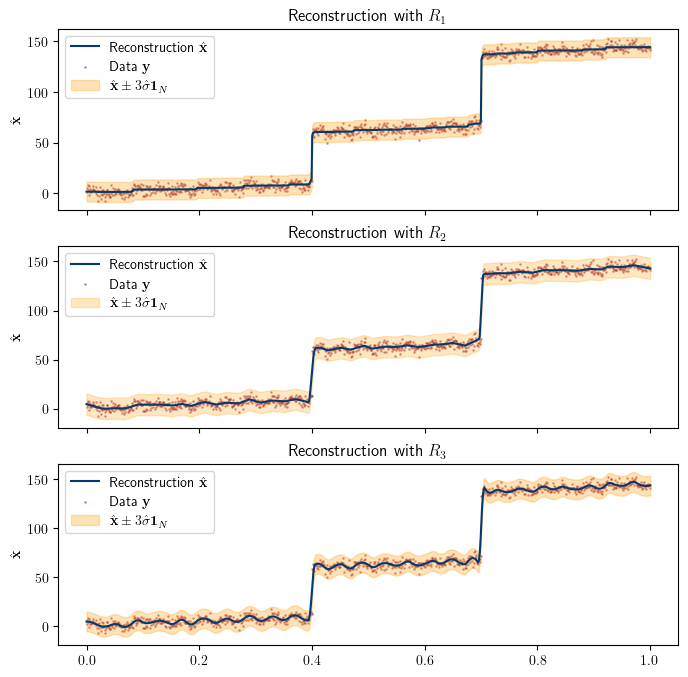

In [168]:
fig, axs = plt.subplots(3, 1, figsize=(8,8))

# ys_r = [data_r1["x"], data_r2["x"], data_r3["x"]]
# noise_vars = [ data_r1["noise_var"], data_r2["noise_var"], data_r3["noise_var"]  ]

xs = [dom, dom, dom]
ys_r = [data_pr1["x"], data_pr2["x"], data_pr3["x"]]
ys_data = [y_obs, y_obs, y_obs]
xs_thetas = [dom[:-1], dom[:-2], dom[:-3]]
ys_thetas = [data_r1["theta"], data_r2["theta"], data_r3["theta"]]
ys_rxs = [ R1_mat @ data_r1["x"], R2_mat @ data_r2["x"], R3_mat @ data_r3["x"]  ]
rx_labels = [ "$R_1 \hat{\mathbf{x}}$", "$R_2 \hat{\mathbf{x}}$", "$R_3 \hat{\mathbf{x}}$"  ]
titles = [  "Reconstruction with $R_1$",  "Reconstruction with $R_2$",  "Reconstruction with $R_3$" ]
noise_vars = [ data_r1["noise_var"], data_r2["noise_var"], data_r3["noise_var"]  ]

end = 2000
i = 0
axs[0].plot(xs[i][:end], ys_r[i][:end], color=dcolors["river_navy"] , label="Reconstruction $\hat{\mathbf{ x }}$")
axs[0].scatter(xs[i][:end], ys_data[i][:end], s=0.9, alpha=0.4, color=dcolors["bonfire_red"], label="Data $\mathbf{y}$")
axs[0].set_xticklabels([])  # Hide x-ticks for cleaner look
axs[0].set_ylabel('$\hat{\mathbf{x}}$')
axs[0].set_title(titles[i])
axs[0].fill_between(xs[i][:end],  ys_r[i][:end] - 3*np.sqrt(noise_vars[i]) ,  ys_r[i][:end] + 3*np.sqrt(noise_vars[i]) , alpha=0.3, label="$\hat{\mathbf{x}} \pm 3 \hat{\sigma} \mathbf{1}_{N}$" , color=dcolors["bonfire_orange"] )
axs[0].legend()

i = 1
axs[1].plot(xs[i][:end], ys_r[i][:end], color=dcolors["river_navy"] , label="Reconstruction $\hat{\mathbf{ x }}$")
axs[1].scatter(xs[i][:end], ys_data[i][:end], s=0.9, alpha=0.4, color=dcolors["bonfire_red"], label="Data $\mathbf{y}$")
axs[1].set_xticklabels([])  # Hide x-ticks for cleaner look
axs[1].set_ylabel('$\hat{\mathbf{x}}$')
axs[1].set_title(titles[i])
axs[1].fill_between(xs[i][:end],  ys_r[i][:end] - 3*np.sqrt(noise_vars[i]) ,  ys_r[i][:end] + 3*np.sqrt(noise_vars[i]) , alpha=0.25, label="$\hat{\mathbf{x}} \pm 3 \hat{\sigma} \mathbf{1}_{N}$" , color=dcolors["bonfire_orange"] )
axs[1].legend()

i = 2
axs[2].plot(xs[i][:end], ys_r[i][:end], color=dcolors["river_navy"] , label="Reconstruction $\hat{\mathbf{ x }}$")
axs[2].scatter(xs[i][:end], ys_data[i][:end], s=0.9, alpha=0.4, color=dcolors["bonfire_red"], label="Data $\mathbf{y}$")
#axs[2].set_xticklabels([])  
axs[2].set_ylabel('$\hat{\mathbf{x}}$')
axs[2].set_title(titles[i])
axs[2].fill_between(xs[i][:end],  ys_r[i][:end] - 3*np.sqrt(noise_vars[i]) ,  ys_r[i][:end] + 3*np.sqrt(noise_vars[i]) , alpha=0.3, label="$\hat{\mathbf{x}} \pm 3 \hat{\sigma} \mathbf{1}_{N}$" , color=dcolors["bonfire_orange"] )
axs[2].legend()

fig.savefig("reconstruction_comparison_small.png", dpi=250, bbox_inches="tight")
fig.savefig("reconstruction_comparison_small.eps", bbox_inches="tight")

plt.show()


In [165]:
noise_var_R1 = data_r1["noise_var"]
noise_var_R2 = data_r2["noise_var"]
noise_var_R3 = data_r3["noise_var"]

print("Without priorconditioning")
print(f"learned noise variance with R1: {noise_var_R1}")
print(f"learned noise variance with R2: {noise_var_R2}")
print(f"learned noise variance with R3: {noise_var_R3}")

Without priorconditioning
learned noise variance with R1: 10.733346042219713
learned noise variance with R2: 13.098133927950713
learned noise variance with R3: 11.246910037237114


In [166]:
noise_var_R1 = data_pr1["noise_var"]
noise_var_R2 = data_pr2["noise_var"]
noise_var_R3 = data_pr3["noise_var"]

print("With priorconditioning")
print(f"learned noise variance with R1: {noise_var_R1}")
print(f"learned noise variance with R2: {noise_var_R2}")
print(f"learned noise variance with R3: {noise_var_R3}")

With priorconditioning
learned noise variance with R1: 10.543749607494254
learned noise variance with R2: 12.915287724209056
learned noise variance with R3: 11.218274726947225
